In [1]:
import numpy
from matplotlib import pyplot
%matplotlib inline

In [2]:
import numba
from numba import jit

In [3]:
nx, ny = 5, 5
Lx, Ly = 1., 1.
dx, dy = int( Lx / ( nx - 1 ) ), int( Ly / ( ny - 1 ) )
x = numpy.linspace( 0., Lx, nx )
y = numpy.linspace( 0., Ly, ny )
u0 = numpy.zeros( ( ny, nx ) )
u0[ :, 0 ] = 1.
u0[ -1, : ] = 1.
u0[ 0, : ] = 1.
b = numpy.ones( ( ny, nx ) ) * .5 * .25**2

In [4]:
@jit(nopython=True)
def poisson_jacobi( u0, maxiter=20000, rtol=1e-6 ):
    
    u = u0.copy()
    diff = rtol + 1
    ite = 0
    conv = []
    while ite < maxiter and diff > rtol:
        
        un = u.copy()
        
        u[1:-1, 1:-1] = 0.25 * (un[1:-1, :-2] + un[1:-1, 2:] + un[:-2, 1:-1] + un[2:, 1:-1])
        
        ite += 1
        diff = numpy.linalg.norm( u - un ) / numpy.linalg.norm( un ) 
        conv.append( diff )
    return u, ite, conv

In [5]:
@jit(nopython=True)
def poisson_sor( u0, omega, maxiter=20000, rtol=1e-6 ):
    
    u = u0.copy()
    diff = rtol + 1
    ite = 0
    conv = []
    while ite < maxiter and diff > rtol:
        
        un = u.copy()
        
        for j in range(1, ny - 1):

                for i in range(1, nx - 1):

                    u[j, i] = (1.0 - omega) * u[j, i] + omega * 0.25 * (u[j, i - 1] + u[j, i + 1] + u[j - 1, i] + u[j + 1, i])

        ite += 1
        diff = numpy.linalg.norm( u - un ) / numpy.linalg.norm( un ) 
        conv.append( diff )
    return u, ite, conv

In [6]:
@jit(nopython=True)
def poisson_gauss_seidel( u0, b, nx, ny, maxiter=20000, rtol=1e-6 ):
    
    u = u0.copy()
    diff = rtol + 1
    ite = 0
    conv = []
    while ite < maxiter and diff > rtol:
        
        un = u.copy()
        
        for j in range(1, ny - 1):

                for i in range(1, nx - 1):

                    u[j, i] = 0.25 * (u[j, i - 1] + u[j, i + 1] + u[j - 1, i] + u[j + 1, i] - b[ j, i ] )

        ite += 1
        diff = numpy.linalg.norm(u - un ) / numpy.linalg.norm( un ) 
        conv.append( diff )
    return u, ite, conv

In [13]:
%%timeit
uj, itej, convj = poisson_jacobi( u0 )

37.2 µs ± 260 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [14]:
%%timeit
omega = 1.
us, ites, convs = poisson_sor( u0, omega )

53.1 µs ± 357 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [15]:
%%timeit
ug, iteg, convg = poisson_gauss_seidel( u0, b, nx, ny )

81.4 µs ± 1.16 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [10]:
print( itej, ites, iteg )

36 20 20


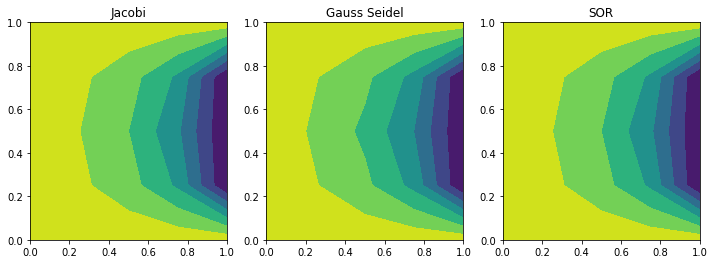

In [11]:
X, Y = numpy.meshgrid( x, y )
pyplot.figure( figsize = ( 12, 4 ))
pyplot.subplot( 1, 3, 1 )
pyplot.contourf( X, Y, uj)
pyplot.title( 'Jacobi' )
pyplot.subplot( 1, 3, 2 )
pyplot.contourf( X, Y, ug)
pyplot.title( 'Gauss Seidel' )
pyplot.subplot( 1, 3, 3 )
pyplot.contourf( X, Y, us)
pyplot.title( 'SOR' );

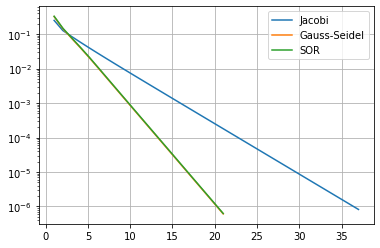

In [12]:
pyplot.semilogy( numpy.linspace( 1, itej+1, itej ), convj, label = 'Jacobi' )

pyplot.semilogy( numpy.linspace( 1, iteg+1, iteg ), convg, label = 'Gauss-Seidel' )

pyplot.semilogy( numpy.linspace( 1, ites+1, ites ), convs, label = 'SOR' );
pyplot.grid()
pyplot.legend()